# Simple Training with the 🤗 Transformers Trainer

Introduction to fine-tuning with 🤗 Transformers.

This notebook takes bits and pieces from:

* [Simple Training with the 🤗 Transformers Trainer](https://www.youtube.com/watch?v=u--UVvH-LIQ&t=132s) video with Lewis Tunstall & HuggingFace 🤗
* Chapter 2: Text Classification, [Natural Language Processing with Transformers; Tunstall, von Werra, Wolf, May 2022](https://transformersbook.com/)
* [Hugging Face Reading Group: Session 2](https://www.youtube.com/watch?v=vGwsyMrblxM&t=416s&ab_channel=HuggingFace) video

----

## Prepare for sharing a new model

Open up an SSH shell, and log in to your vm instance.

Activate your Python virtual environment.

Using the `huggingface-cli` command-line utility, log in to HuggingFace and enter your write token.

    # log in to Huggingface, and enter your write Role user access token
    huggingface-cli login

    # create a new Huggingface repo for this model
    huggingface-cli repo create test-minilm-finetuned-emotion

## Dataset: EDA & preparation

In the Simple Training with the 🤗 Transformers Trainer video, the `emotions` dataset was being used, but apparently the original owners of the `emotions` dataset removed it early December of 2022. Please see [Emotion dataset cannot be downloaded #5342](https://github.com/huggingface/datasets/issues/5342) and [Data files are no longer accessible #5](https://github.com/dair-ai/emotion_dataset/issues/5) for more details.

In its stead, the [SetFit team](https://huggingface.co/SetFit) (which include Lewis Tunstall amongst its members) have provided the [`SetFit/emotion`](https://huggingface.co/datasets/SetFit/emotion) dataset. This notebook has been tweaked for using `SetFit/emotion`.

In [1]:
from datasets import load_dataset

emotions = load_dataset("SetFit/emotion")
emotions

Using custom data configuration SetFit--emotion-e444b7640ce3116e
Found cached dataset json (/home/buruzaemon/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [2]:
emotions["train"].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'label_text': Value(dtype='string', id=None)}

What do the dataset items look like?

In [3]:
emotions["train"][0]

{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}

Sometimes, it is easier to inspect a dataset as a Pandas DataFrame.

In [4]:
emotions.set_format(type="pandas")
train_df = emotions["train"][:]
train_df.head()

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


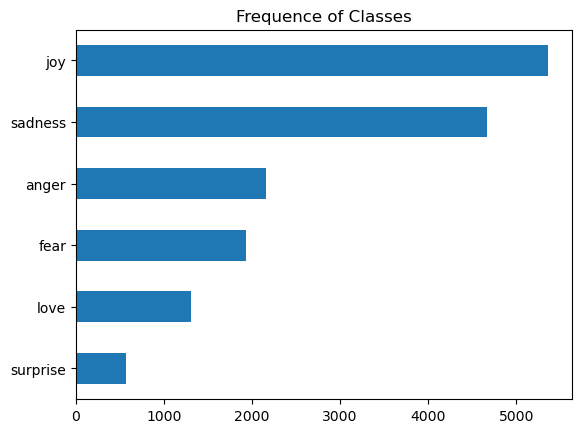

In [5]:
import matplotlib.pyplot as plt

train_df["label_text"].value_counts(ascending=True).plot.barh()
plt.title("Frequence of Classes")
plt.show()

train_df["words_per_tweet"] = train_df["text"].str.split().apply(len)
train_df.boxplot(
    "words_per_tweet",
    by="label_text",
    grid=False,
    showfliers=False,
    color="black"
)
plt.title("Words Per Tweet")
plt.suptitle("")
plt.xlabel("")
plt.show()

----

Notice that the frequency of class "5" for "surprise" is not well represented within the dataset.

_How do we deal with this?_

----

## Dealing with imbalanced classes

Now, when training a classfier using a dataset that may suffer for imbalanced classes, one way to deal with the situation is to up-sample from the imbalanced class(es) to offset the difference(s). However, Transformer models are good at memorizing patterns, so this might not be a good idea in our case.

What we can do is this: correct for the class imbalance _within the loss function during training_.

From the [Trainer](https://huggingface.co/docs/transformers/main_classes/trainer#trainer) documentation:

> To inject custom behavior you can subclass them and override the following methods: ...
> * `compute_loss` - Computes the loss on a batch of training inputs.


From PyTorch docs on [`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html):

> If provided, <span style="background-color: #9AFEFF">the optional argument weight should be a 1D Tensor assigning weight to each of the classes. This is particularly useful when you have an unbalanced training set.</span>

In [6]:
import pandas as pd

kvs = pd.unique(train_df[['label', 'label_text']].values.ravel('C'))
kvs

array([0, 'sadness', 3, 'anger', 2, 'love', 5, 'surprise', 4, 'fear', 1,
       'joy'], dtype=object)

In [7]:
id2label = dict(zip(kvs[0::2], kvs[1::2]))
id2label

{0: 'sadness', 3: 'anger', 2: 'love', 5: 'surprise', 4: 'fear', 1: 'joy'}

In [8]:
label2id = {k:v for v,k in id2label.items()}
label2id

{'sadness': 0, 'anger': 3, 'love': 2, 'surprise': 5, 'fear': 4, 'joy': 1}

In [9]:
n_classes = len(id2label)
n_classes

6

In [10]:
class2prob = train_df["label"].value_counts(normalize=True)
for i,v in class2prob.items():
    print(f"{id2label[i]:<10} {v:.5F}")

joy        0.33513
sadness    0.29163
anger      0.13494
fear       0.12106
love       0.08150
surprise   0.03575


In [11]:
class_weights = (1 - (train_df["label"].value_counts().sort_index() / len(train_df))).values
print(class_weights)
print(type(class_weights))

[0.708375  0.664875  0.9185    0.8650625 0.8789375 0.96425  ]
<class 'numpy.ndarray'>


Seriously, wtf?

If we don't expressly put `class_weights` on the GPU, like if we left it on the CPU, we would see this:


    RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument weight in method wrapper_nll_loss_forward)

Not completely unhelpful, but still somewhat cryptic. You might like to read [CUDA SEMANTICS in the PyTorch documentation](https://pytorch.org/docs/stable/notes/cuda.html#cuda-semantics).

In [12]:
import torch

class_weights = torch.from_numpy(class_weights).float().to("cuda")

# THIS example leaves class_weights on the CPU..
#class_weights = torch.from_numpy(class_weights).float()

class_weights
print(type(class_weights))
print(class_weights.dim())

<class 'torch.Tensor'>
1


In [13]:
from torch import nn
import torch
from transformers import Trainer


class WeightedLossTrainer(Trainer):
    
    def compute_loss(self, model, inputs, return_outputs=False):
        # feed inputs to model and extract logits
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # extract labels; not label!
        #         ^^^^^
        labels = inputs.get("labels")
        
        # define loss function with class weights
        loss_func = nn.CrossEntropyLoss(weight=class_weights)
        
        # compute loss
        loss = loss_func(logits, labels)
        
        return (loss, outputs) if return_outputs else loss

----

After wrapping up the EDA with Pandas DataFrames, be sure to reset the Dataset format.

In [14]:
emotions.reset_format()

----

## Pre-trained model: MiniLM

[microsoft/MiniLM-L12-H384-uncased](https://huggingface.co/microsoft/MiniLM-L12-H384-uncased?text=I+like+you.+I+love+you) on Hugging Face modelhub.

> Pre-trained language models (e.g., BERT (Devlin et al., 2018) and its variants) have achieved remarkable success in varieties of NLP tasks. However, these models usually consist of hundreds of millions of parameters which brings challenges for fine-tuning and online serving in real-life applications due to latency and capacity constraints. In this work, we present a simple and effective approach to compress large Transformer (Vaswani et al., 2017) based pre-trained models, termed as deep self-attention distillation. The small model (student) is trained by deeply mimicking the self-attention module, which plays a vital role in Transformer networks, of the large model (teacher). Specifically, we propose distilling the self-attention module of the last Transformer layer of the teacher, which is effective and flexible for the student. Furthermore, we introduce the scaled dot-product between values in the self-attention module as the new deep self-attention knowledge, in addition to the attention distributions (i.e., the scaled dot-product of queries and keys) that have been used in existing works. Moreover, we show that introducing a teacher assistant (Mirzadeh et al., 2019) also helps the distillation of large pre-trained Transformer models. Experimental results demonstrate that our monolingual model outperforms state-of-the-art baselines in different parameter size of student models. In particular, it retains more than 99% accuracy on SQuAD 2.0 and several GLUE benchmark tasks using 50% of the Transformer parameters and computations of the teacher model. We also obtain competitive results in applying deep self-attention distillation to multilingual pre-trained models.

Read the [MiniLM: Deep Self-Attention Distillation for Task-Agnostic Compression of Pre-trained Transformers](https://arxiv.org/abs/2002.10957) paper.

In [15]:
checkpoint = "microsoft/MiniLM-L12-H384-uncased"

## Tokenization

...

In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Let's see how this particular tokenizer works with the example text "Tokenizing text is a core task of NLP."

In [17]:
ex_text = "Tokenizing text is a core task of NLP."

encoded_text = tokenizer(ex_text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


`input_ids`

> Index ids of the word embeddings corresponding to the given word.

`token_type_ids`

> ... a binary mask identifying the two types of sequence in the model ...
> ... the “context” used for the question, has all its tokens represented by a 0, whereas the second sequence, corresponding to the “question”, has all its tokens represented by a 1...
> Some models, like XLNetModel use an additional token represented by a 2.

`attention_mask`

> Attention masks are tensors with the exact same shape as the input IDs tensor, filled with 0s and 1s: 1s indicate the corresponding tokens should be attended to, and 0s indicate the corresponding tokens should not be attended to (i.e., they should be ignored by the attention layers of the model).

OK, so, what exactly are these _tokens_?

In [18]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [19]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


And, diving in just a little bit deeper...

The Tokenizer is actually a pipeline with:

1. Normalization
1. Pre-tokenization
1. Model (?)
1. Postprocessor

Let's have a look at these ... in turn.

In [20]:
#help(tokenizer)

In [21]:
#help(tokenizer.backend_tokenizer)

In [22]:
sentence = ex_text

print(f"The original input sentence: '{sentence}'")

The original input sentence: 'Tokenizing text is a core task of NLP.'


In [23]:
sentence = tokenizer.backend_tokenizer.normalizer.normalize_str(sentence)

print(f"Normalization: '{sentence}'")

Normalization: 'tokenizing text is a core task of nlp.'


In [24]:
tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(sentence)

[('tokenizing', (0, 10)),
 ('text', (11, 15)),
 ('is', (16, 18)),
 ('a', (19, 20)),
 ('core', (21, 25)),
 ('task', (26, 30)),
 ('of', (31, 33)),
 ('nlp', (34, 37)),
 ('.', (37, 38))]

In [25]:
tokenizer(sentence)[0].tokens

['[CLS]',
 'token',
 '##izing',
 'text',
 'is',
 'a',
 'core',
 'task',
 'of',
 'nl',
 '##p',
 '.',
 '[SEP]']

In [26]:
tokenizer(emotions["train"]["text"][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [27]:
def tokenize_text(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=512)

In [28]:
emotions_encoded = emotions.map(tokenize_text, batched=True, batch_size=None)
emotions_encoded

Loading cached processed dataset at /home/buruzaemon/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-6336669b1e9f9c00.arrow
Loading cached processed dataset at /home/buruzaemon/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-beb5484d00294ab2.arrow
Loading cached processed dataset at /home/buruzaemon/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-ca5830f5be51e028.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [29]:
emotions_encoded["train"].column_names

['text',
 'label',
 'label_text',
 'input_ids',
 'token_type_ids',
 'attention_mask']

In [30]:
emotions["train"].column_names

['text', 'label', 'label_text']

From the API docs on Trainer:

> The Trainer class is optimized for 🤗 Transformers models and can have surprising behaviors when you use it on other models. When using it on your own model, make sure:
>
> * your model always return tuples or subclasses of ModelOutput.
> * your model can compute the loss if a labels argument is provided and that loss is returned as the first element of the tuple (if your model returns tuples)
> * your model can accept multiple label arguments (use the label_names in your TrainingArguments to indicate their name to the Trainer) but none of them should be named "label".

So, <span style="background-color: #9AFEFF">we need to rename that column for `label` in our dataset to `labels`</span>.

In [31]:
emotions_encoded = emotions_encoded.rename_column("label", "labels")
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'labels', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'labels', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

----

## Now bring it all together!

In [32]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    num_labels=n_classes,
    id2label=id2label,
    label2id=label2id
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
from sklearn.metrics import f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    return {"f1": f1}

When you first attempt to train your model, you may see the following warning coming from your `TrainingArguments`:

    /opt/conda/envs/transformers-py38/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


This is only just a warning, but some background: the present default optimizer `AdamW` from Huggingface is eventually going to go away. sgugger recommends using `adamw_torch`, which is the PyTorch implementation [`torch.optim.AdamW`](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html) (see [API documentation of `optim` argument for `TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.optim))

Please see sgugger's response in [Huggingface transformers longformer optimizer warning AdamW](https://discuss.huggingface.co/t/huggingface-transformers-longformer-optimizer-warning-adamw/14711/2)

In [34]:
from transformers import TrainingArguments

batch_size = 64

logging_steps = len(emotions_encoded["train"]) // batch_size

output_dir = "test-minilm-finetuned-emotion"

training_args = TrainingArguments(
    optim="adamw_torch",
    output_dir=output_dir,
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_steps=logging_steps,
    fp16=True,
    push_to_hub=False
)

In [35]:
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer
)

Using cuda_amp half precision backend


You may see a message stating <code>Using cuda_amp half precision backend</code>.

From [Nvidia, Deep Learning Performance Documentation, Train with Mixed Precision](https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html)...
> There are numerous benefits to using numerical formats with lower precision than 32-bit floating point. First, they require less memory, enabling the training and deployment of larger neural networks. Second, they require less memory bandwidth which speeds up data transfer operations. Third, math operations run much faster in reduced precision, especially on GPUs with Tensor Core support for that precision. Mixed precision training achieves all these benefits while ensuring that no task-specific accuracy is lost compared to full precision training. It does so by identifying the steps that require full precision and using 32-bit floating point for only those steps while using 16-bit floating point everywhere else.

c.f. [CUDA Automatic Mixed Precision Examples](https://pytorch.org/docs/stable/notes/amp_examples.html#cuda-automatic-mixed-precision-examples)

In [36]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_text, text. If label_text, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 16000
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 1250
  Number of trainable parameters = 33362310
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,1.352200,0.974722,0.618269
2,0.821400,0.606995,0.856834
3,0.549300,0.453421,0.899541
4,0.414400,0.370763,0.917418
5,0.358500,0.350489,0.916601


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_text, text. If label_text, text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 64
Saving model checkpoint to test-minilm-finetuned-emotion/checkpoint-500
Configuration saved in test-minilm-finetuned-emotion/checkpoint-500/config.json
Model weights saved in test-minilm-finetuned-emotion/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-minilm-finetuned-emotion/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-minilm-finetuned-emotion/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: label_text, text. If label_text, text are not expected by `BertForS

TrainOutput(global_step=1250, training_loss=0.6991485900878907, metrics={'train_runtime': 232.419, 'train_samples_per_second': 344.206, 'train_steps_per_second': 5.378, 'total_flos': 895521735360000.0, 'train_loss': 0.6991485900878907, 'epoch': 5.0})

----

## Transformers as Feature Extractors

### from Chapter 2: Text Classification, Natural Language Processing with Transformers

In [43]:
ch2_checkpoint = "distilbert-base-uncased"

In [45]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(ch2_checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

loading configuration file config.json from cache at /home/buruzaemon/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

loading file vocab.txt from cache at /home/buruzaemon/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /home/buruzaemon/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /home/buruzaemon/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /home/buruzaemon/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "att

In [46]:
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(ch2_checkpoint).to(device)

loading configuration file config.json from cache at /home/buruzaemon/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.25.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /home/buruzaemon/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/pytorch_model.bin
Some weights of the model checkpoint at distilbert-base-uncased

In [53]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Inputs tensor shape: {inputs['input_ids'].size()}")

Inputs tensor shape: torch.Size([1, 6])


In [48]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [52]:
print(f"Outputs tensor shape: {outputs.last_hidden_state.size()}")

Outputs tensor shape: torch.Size([1, 6, 768])


In [51]:
outputs.last_hidden_state[:, 0].size()

torch.Size([1, 768])

----

## Try out our newly-trained model

In [ ]:
from transformers import pipeline

pipl = pipeline("text-classification", 
                model="buruzaemon/test-minilm-finetuned-emotion")

In [ ]:
pipl("I am sorry to see you go")